# Master in Applied Artificial Intelligence

## Course: *Fintech and Digital Innovation in Finance*

### **Course Project – Part 1**
### Text Embeddings and Technical Analysis on S&P 500 Data (*Section A*)

---

**Institution:** Tecnológico de Monterrey

**Instructors:** Marie-Ève Malette, Yetnalezi Quintas Ruiz

**Author:** Alejandro Díaz Villagómez | A01276769

**Date:** July 28th, 2025

---

# Introduction to text embeddings on S&P 500 news

# 📌 Objectives

By the end of this notebook, students will be able to:

1. **Retrieve Financial News:**
   - Use the `yfinance` library to gather news headlines for all companies in the S&P 500 index.

2. **Clean and Structure Financial Text Data:**
   - Extract and organize relevant metadata (e.g., ticker, title, summary, publication date, URL) into a structured pandas DataFrame.

3. **Generate Text Embeddings:**
   - Apply a pre-trained sentence transformer model (`all-MiniLM-L6-v2`) to convert news headlines and summaries into numerical embeddings.

4. **Apply Clustering Techniques:**
   - Use K-Means clustering to identify groups of similar news articles based on semantic content.

5. **Determine Optimal Number of Clusters:**
   - Evaluate clustering quality using silhouette scores to find the best number of clusters.

6. **Visualize High-Dimensional Embeddings:**
   - Reduce the embedding space using PCA and visualize clusters in two dimensions.

7. **Interpret Cluster Themes:**
   - Analyze representative news


## Install and Import important librairies

In [1]:
# !pip install -q yfinance pandas lxml tqdm sentence-transformers ipywidgets scikit-learn matplotlib
# !pip freeze > ../requirements.txt

In [2]:
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics import silhouette_score
import yfinance as yf
import numpy as np

## Get the list of stocks in the S&P 500 

In [3]:
# Read and print the stock tickers that make up S&P500
df_tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
display(df_tickers.head())

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [4]:
ticker_list = df_tickers['Symbol'].tolist()
print("Sample tickers:", ticker_list[:10])

Sample tickers: ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']


## Get the news of all 500 stocks in the S&P 500 Index
Use the yfinance library to retrieve the news of all 500 stocks in the index.
https://ranaroussi.github.io/yfinance/reference/yfinance.stock.html

### Get the news in a dictionary

In [5]:
# Create a dictionary where the keys are the symbols (tickers) of each 500 stocks 
# and the value is the output news from the yfinance library

from tqdm import tqdm
import time

# Dictionary to store ticker: news_list
ticker_news_dict = {}

# Loop through each ticker and collect news
for ticker in tqdm(ticker_list, desc="Fetching news"):
    try:
        stock = yf.Ticker(ticker)
        news_items = stock.news
        ticker_news_dict[ticker] = news_items  # Store full news list (even if empty)
        time.sleep(0.2)  # Prevent rate limiting
    except Exception as e:
        print(f"Error fetching news for {ticker}: {e}")
        ticker_news_dict[ticker] = []

Fetching news: 100%|██████████| 503/503 [03:45<00:00,  2.23it/s]


In [6]:
print("Sample ticker_news_dict entry:")
print("-" * 50)

# Find the first ticker with at least one news article
for ticker, news_list in ticker_news_dict.items():
    if news_list:  # If the list is not empty
        print(f"TICKER: {ticker}")
        print(f"Number of articles: {len(news_list)}")
        print("-" * 30)
        # Print the first news article in a readable format
        first_article = news_list[0]
        for k, v in first_article.get("content", {}).items():
            print(f"{k}: {v}")
        break

Sample ticker_news_dict entry:
--------------------------------------------------
TICKER: MMM
Number of articles: 10
------------------------------
id: 70669b9e-2b94-3b39-b30e-c4b59ce9f9f3
contentType: STORY
title: UBS Affirms ‘Buy’ Stance on 3M Co (MMM) as Q2 Results Impress on Organic Growth
description: 
summary: 3M Company (NYSE:MMM) is one of the defensive stocks billionaires are buying amid US trade tariff uncertainty. On July 21, UBS reiterated a ‘Buy’ rating on the stock and a $184 price target. The positive stance stems from the company delivering better-than-expected second-quarter results, as it also increased its full-year earnings per share guidance. The […]
pubDate: 2025-07-31T04:23:44Z
displayTime: 2025-07-31T04:23:44Z
isHosted: True
bypassModal: False
previewUrl: None
thumbnail: {'originalUrl': 'https://media.zenfs.com/en/insidermonkey.com/455bfa79d6103f202da4a30bafd2536d', 'originalWidth': 1456, 'originalHeight': 816, 'caption': 'UBS Affirms ‘Buy’ Stance on 3M Co (MMM)

### Structure the news into a pandas dataframe 

Your final dataframe should have the following columns: 
- TICKER
- TITLE (of the news)
- SUMMARY (of the news)
- PUBLICATION_DATE (of the news)
- URL (of the news)

Note: all of those fields are provided in the yfinance news component. Refer to the library documentation.

In [7]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

# Initialize an empty list to store structured news entries
news_data = []

# Loop through each ticker and its associated news list
for ticker, news_items in ticker_news_dict.items():
    for item in news_items:
        content = item.get("content", {})
        if isinstance(content, dict):  # Some may be malformed
            news_data.append({
                "TICKER": ticker,
                "TITLE": content.get("title"),
                "SUMMARY": content.get("summary"),
                "PUBLICATION_DATE": pd.to_datetime(content.get("pubDate")),
                "URL": content.get("canonicalUrl", {}).get("url")
            })

In [8]:
print("Sample news_data entry:")
print("-" * 50)
for k, v in news_data[0].items():
    print(f"{k}: {v}")

Sample news_data entry:
--------------------------------------------------
TICKER: MMM
TITLE: UBS Affirms ‘Buy’ Stance on 3M Co (MMM) as Q2 Results Impress on Organic Growth
SUMMARY: 3M Company (NYSE:MMM) is one of the defensive stocks billionaires are buying amid US trade tariff uncertainty. On July 21, UBS reiterated a ‘Buy’ rating on the stock and a $184 price target. The positive stance stems from the company delivering better-than-expected second-quarter results, as it also increased its full-year earnings per share guidance. The […]
PUBLICATION_DATE: 2025-07-31 04:23:44+00:00
URL: https://finance.yahoo.com/news/ubs-affirms-buy-stance-3m-042344680.html


In [9]:
# Convert list of dictionaries into a DataFrame
df_news = pd.DataFrame(news_data)

# Display basic info
print(f"Total news articles collected: {len(df_news)}")
print("-" * 50)
display(df_news.head())

Total news articles collected: 5020
--------------------------------------------------


,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL
0,MMM,UBS Affirms ‘Buy’ Stance on 3M Co (MMM) as Q2 ...,3M Company (NYSE:MMM) is one of the defensive ...,2025-07-31 04:23:44+00:00,https://finance.yahoo.com/news/ubs-affirms-buy...
1,MMM,3M’s (MMM) Commitment to Innovation Drives Div...,3M Company (NYSE:MMM) is included among the 11...,2025-07-30 17:18:30+00:00,https://finance.yahoo.com/news/3m-mmm-commitme...
2,MMM,Industrial sector outperformance: 3 themes to ...,The industrial sector (XLI) has outperformed t...,2025-07-29 20:54:55+00:00,https://finance.yahoo.com/video/industrial-sec...
3,MMM,Why Investors Need to Take Advantage of These ...,Finding stocks expected to beat quarterly earn...,2025-07-29 13:00:02+00:00,https://finance.yahoo.com/news/why-investors-a...
4,MMM,3M Company (MMM): “I Was Surprised” By The Org...,We recently published 12 Stocks Jim Cramer Tal...,2025-07-24 09:03:00+00:00,https://finance.yahoo.com/news/3m-company-mmm-...


## Exploring text embeddings

- Use the open-source model: 'sentence-transformers/all-MiniLM-L6-v2' to create embeddings on the news title and summary
- Add a column to your news dataframe called EMBEDDED_TEXT using ONLY the TITLE of the news
- Add a column to your news dataframe called EMBEDDINGS, which contains the embedding of EMBEDDED_TEXT

In [10]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

# Load the model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Add 'EMBEDDED_TEXT' column using only the TITLE of the news
df_news['EMBEDDED_TEXT'] = df_news['TITLE']

# Add 'EMBEDDINGS' column with embeddings of 'EMBEDDED_TEXT'
embeddings = model.encode(df_news['EMBEDDED_TEXT'].tolist(), show_progress_bar=True)
df_news['EMBEDDINGS'] = embeddings.tolist()

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

In [11]:
print("Sample of new DataFrame:")
print("-" * 50)
display(df_news[["TITLE", "EMBEDDED_TEXT", "EMBEDDINGS"]].head())

Sample of new DataFrame:
--------------------------------------------------


,TITLE,EMBEDDED_TEXT,EMBEDDINGS
0,UBS Affirms ‘Buy’ Stance on 3M Co (MMM) as Q2 ...,UBS Affirms ‘Buy’ Stance on 3M Co (MMM) as Q2 ...,"[-0.03539247438311577, -0.0387418307363987, -0..."
1,3M’s (MMM) Commitment to Innovation Drives Div...,3M’s (MMM) Commitment to Innovation Drives Div...,"[-0.003212510608136654, -0.09891524165868759, ..."
2,Industrial sector outperformance: 3 themes to ...,Industrial sector outperformance: 3 themes to ...,"[0.04115184023976326, -0.056558672338724136, -..."
3,Why Investors Need to Take Advantage of These ...,Why Investors Need to Take Advantage of These ...,"[0.01292478572577238, -0.074495829641819, 0.04..."
4,3M Company (MMM): “I Was Surprised” By The Org...,3M Company (MMM): “I Was Surprised” By The Org...,"[0.006455391179770231, -0.10904762148857117, -..."


## Using K-means clustering on news embeddings
to simplify, keep only one news for each company (ticker), you should have 500 rows in your news dataframe

In [12]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

# Keep only the first news per ticker
df_unique_news = df_news.sort_values(by="PUBLICATION_DATE", ascending=False).drop_duplicates(subset="TICKER")

# Ensure there are exactly 500
df_unique_news = df_unique_news.head(500)

print(f"News entries after selecting one per ticker: {df_unique_news.shape[0]}")
print("-" * 50)
display(df_unique_news.head())

News entries after selecting one per ticker: 500
--------------------------------------------------


,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL,EMBEDDED_TEXT,EMBEDDINGS
3156,MSFT,Confluent Stock Slides 30% After Q2 Results As...,Confluent stock tumbled late Wednesday despite...,2025-07-31 18:30:04+00:00,https://www.investors.com/news/technology/conf...,Confluent Stock Slides 30% After Q2 Results As...,"[0.008171734400093555, -0.048720765858888626, ..."
3096,META,QCOM: Qualcomm Stock Tumbles After Warning App...,Qualcomm Shares Under Pressure as Tariff Fears...,2025-07-31 18:29:58+00:00,https://finance.yahoo.com/news/qcom-qualcomm-s...,QCOM: Qualcomm Stock Tumbles After Warning App...,"[-0.045019589364528656, 0.008790855295956135, ..."
3930,REGN,Trump pressures 17 pharma CEOs to cut US drug ...,U.S. President Donald Trump sent letters to th...,2025-07-31 18:27:59+00:00,https://ca.finance.yahoo.com/news/trump-pressu...,Trump pressures 17 pharma CEOs to cut US drug ...,"[0.05366816371679306, 0.03216208517551422, 0.0..."
2630,JNJ,Trump pressures 17 pharma CEOs to cut US drug ...,U.S. President Donald Trump sent letters to th...,2025-07-31 18:27:59+00:00,https://ca.finance.yahoo.com/news/trump-pressu...,Trump pressures 17 pharma CEOs to cut US drug ...,"[0.053668174892663956, 0.032162103801965714, 0..."
3080,MRK,Trump pressures 17 pharma CEOs to cut US drug ...,U.S. President Donald Trump sent letters to th...,2025-07-31 18:27:59+00:00,https://ca.finance.yahoo.com/news/trump-pressu...,Trump pressures 17 pharma CEOs to cut US drug ...,"[0.05366816371679306, 0.03216208517551422, 0.0..."


### Identify the number of clusters using the silhouette score

- Using a for loop, do the clustering with different k values (number of clusters), test 1 to 6 clusters
- Compute the silhouette score for every k value
- Plot the silhouette score for different k values

#### Try different values of k and compute silhouette scores

In [13]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

# Prepare the feature matrix
X = np.array(df_unique_news["EMBEDDINGS"].tolist())

# Try different values of k from 1 to 6 (excluding 1 for silhouette score)
k_values = range(2, 7)
silhouette_scores = []

print("Calculating silhouette scores...")
print("-" * 50)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)
    print(f"k={k} → Silhouette Score: {score:.4f}")

Calculating silhouette scores...
--------------------------------------------------
k=2 → Silhouette Score: 0.0504
k=3 → Silhouette Score: 0.0508
k=4 → Silhouette Score: 0.0332
k=5 → Silhouette Score: 0.0400
k=6 → Silhouette Score: 0.0253


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


#### Plot silhouette scores

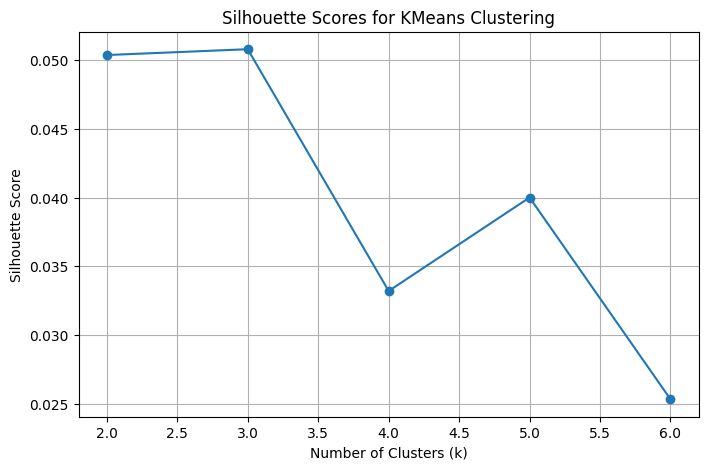

In [14]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Silhouette Scores for KMeans Clustering")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

#### Identify the Best k

In [15]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

best_k = k_values[np.argmax(silhouette_scores)]
print(f"Best number of clusters based on silhouette score: k={best_k}")

Best number of clusters based on silhouette score: k=3


#### Cluster the embeddings using 3 clusters (k=3)

In [16]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

kmeans_final = KMeans(n_clusters=3, random_state=42, n_init='auto')
df_unique_news["CLUSTER"] = kmeans_final.fit_predict(X)
display(df_unique_news[["TICKER", "TITLE", "CLUSTER"]].head(10))

,TICKER,TITLE,CLUSTER
3156,MSFT,Confluent Stock Slides 30% After Q2 Results As...,1
3096,META,QCOM: Qualcomm Stock Tumbles After Warning App...,2
3930,REGN,Trump pressures 17 pharma CEOs to cut US drug ...,0
2630,JNJ,Trump pressures 17 pharma CEOs to cut US drug ...,0
3080,MRK,Trump pressures 17 pharma CEOs to cut US drug ...,0
2860,LLY,Trump pressures 17 pharma CEOs to cut US drug ...,0
4380,TSLA,Trump's Trade Blitz Shocks Markets as Dollar S...,0
2370,HUBB,We Like Hubbell's (NYSE:HUBB) Returns And Here...,2
190,GOOGL,How Trump's 'One Big Beautiful Bill' may fuel ...,0
200,GOOG,How Trump's 'One Big Beautiful Bill' may fuel ...,0


### Visualize the 2 first PCA Components of your embeddings

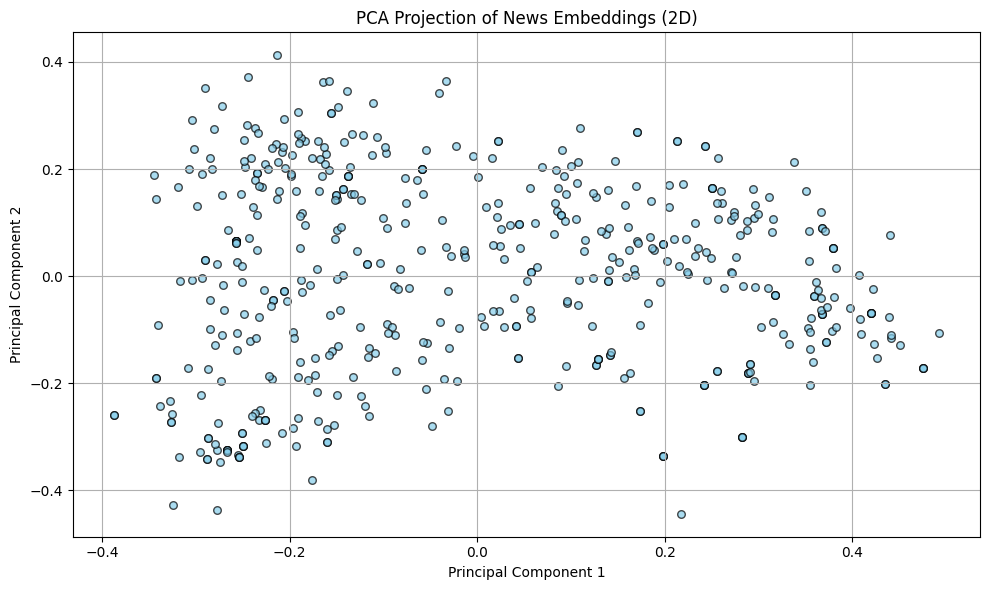

In [17]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

# Reduce to 2 components using PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# Add PCA components to the DataFrame for plotting
df_unique_news["PCA_1"] = X_pca[:, 0]
df_unique_news["PCA_2"] = X_pca[:, 1]

# Plot PCA-reduced embeddings
plt.figure(figsize=(10, 6))
plt.scatter(df_unique_news["PCA_1"], df_unique_news["PCA_2"], alpha=0.7, s=30, c='skyblue', edgecolor='k')
plt.title("PCA Projection of News Embeddings (2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

The PCA (Principal Component Analysis) plot provides a 2D visualization of high-dimensional news embeddings. By projecting the original embedding vectors into two principal components, we can gain intuition about the distribution and potential separability of semantic structures in the news data. Here's what the results suggest:

* **No clearly separable clusters**: The points appear diffusely distributed across the plot, without obvious, compact groupings. This indicates that the semantic content of news headlines across different companies is varied and overlapping.

* **High overlap between embeddings**: The overlapping points suggest that many headlines, even from different companies, share similar themes or vocabulary (especially common in financial markets where macroeconomic news affects multiple stocks).

* **Limitations of PCA**: PCA is a linear dimensionality reduction technique and may not fully capture the complex non-linear relationships in semantic embeddings. Important structures could be obscured or flattened in this 2D space.

> REFERENCES:

* https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
* https://www.geeksforgeeks.org/data-analysis/principal-component-analysis-pca/

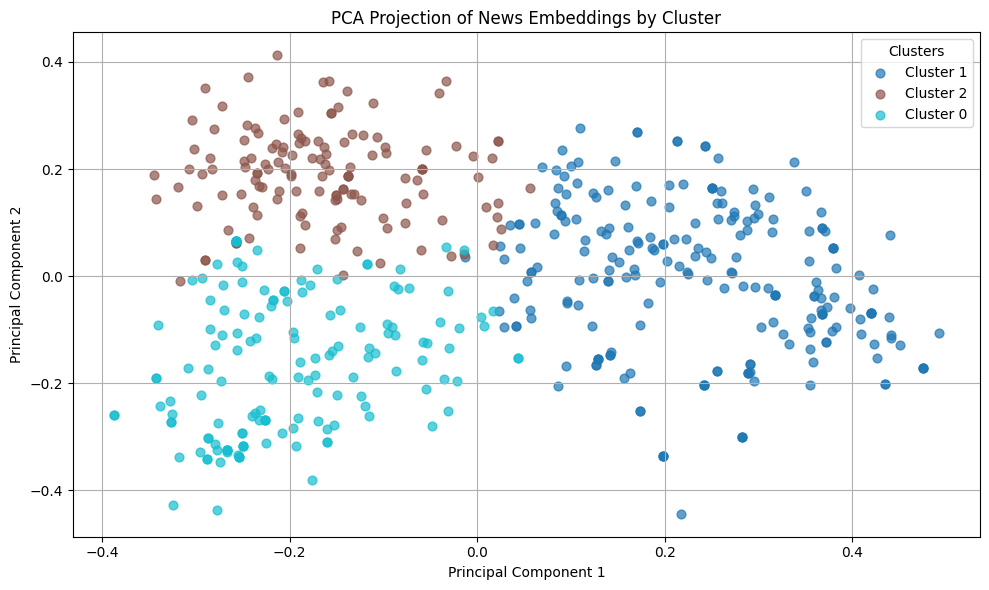

In [18]:
# Number of unique clusters
unique_clusters = df_unique_news["CLUSTER"].unique()
num_clusters = len(unique_clusters)

# Create a colormap using the new recommended method
cluster_to_index = {cluster: i for i, cluster in enumerate(unique_clusters)}
colors = plt.colormaps['tab10'](np.linspace(0, 1, num_clusters)) # This creates an array of colors

# Plot PCA with cluster coloring
plt.figure(figsize=(10, 6))

for cluster in unique_clusters:
    subset = df_unique_news[df_unique_news["CLUSTER"] == cluster]
    
    # Get the color based on the mapped index
    color_to_use = colors[cluster_to_index[cluster]] 

    plt.scatter(
        subset["PCA_1"],
        subset["PCA_2"],
        s=40,
        alpha=0.7,
        label=f"Cluster {cluster}",
        color=color_to_use # Use the color obtained from the array
    )

plt.title("PCA Projection of News Embeddings by Cluster")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Clusters")
plt.grid(True)
plt.tight_layout()
plt.show()

In the initial PCA projection without color coding, the data appeared densely scattered, offering little insight into potential groupings or underlying semantic patterns. However, once color is introduced based on cluster assignments, previously hidden structures emerge clearly. This highlights the critical role of visual encoding (specifically, color) in revealing separable regions within the high-dimensional embedding space.

Color not only enhances interpretability but also validates that the clustering algorithm is capturing meaningful distinctions. What appeared as a uniform cloud of points can now be interpreted as distinct semantic regions, each potentially linked to different themes, tones, or market implications. This transition from an unstructured to a structured view exemplifies how proper visual encoding transforms raw data into actionable insights. 

Key observations include:

* *Semantic Cohesion Within Clusters*: The clusters appear reasonably well-separated in the 2D PCA space, particularly between Cluster 0 and Cluster 2, suggesting that the KMeans algorithm captured meaningful distinctions in news content. This supports the presence of latent topics or sentiment patterns that differentiate groups of companies.

* *Balanced Distribution Across Clusters*: Each cluster contains a comparable number of data points, reducing concerns about imbalance and indicating that diverse semantic patterns are present across S&P 500 companies.

* *Potential for Sectoral or Sentiment Analysis*: If we enrich the dataset with sector metadata or sentiment scores, we could further validate whether certain clusters correspond to specific industries (e.g., tech vs. healthcare) or sentiment polarity (positive vs. negative). This would enhance the interpretability and downstream usability of the clustering.

#### Analyze the content of each cluster
- Add the kmeans cluster label to your news dataframe
- Print the content of each cluster and analyze it

In [19]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

df_unique_news["CLUSTER"] = kmeans_final.labels_

# Show distribution of news per cluster
print("Number of news articles per cluster:")
print("-" * 50)
print(df_unique_news["CLUSTER"].value_counts())
print("-" * 50)
display(df_unique_news.head())

Number of news articles per cluster:
--------------------------------------------------
CLUSTER
1    218
0    149
2    133
Name: count, dtype: int64
--------------------------------------------------


,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL,EMBEDDED_TEXT,EMBEDDINGS,CLUSTER,PCA_1,PCA_2
3156,MSFT,Confluent Stock Slides 30% After Q2 Results As...,Confluent stock tumbled late Wednesday despite...,2025-07-31 18:30:04+00:00,https://www.investors.com/news/technology/conf...,Confluent Stock Slides 30% After Q2 Results As...,"[0.008171734400093555, -0.048720765858888626, ...",1,0.114008,0.046501
3096,META,QCOM: Qualcomm Stock Tumbles After Warning App...,Qualcomm Shares Under Pressure as Tariff Fears...,2025-07-31 18:29:58+00:00,https://finance.yahoo.com/news/qcom-qualcomm-s...,QCOM: Qualcomm Stock Tumbles After Warning App...,"[-0.045019589364528656, 0.008790855295956135, ...",2,0.009039,0.128714
3930,REGN,Trump pressures 17 pharma CEOs to cut US drug ...,U.S. President Donald Trump sent letters to th...,2025-07-31 18:27:59+00:00,https://ca.finance.yahoo.com/news/trump-pressu...,Trump pressures 17 pharma CEOs to cut US drug ...,"[0.05366816371679306, 0.03216208517551422, 0.0...",0,-0.266497,-0.324641
2630,JNJ,Trump pressures 17 pharma CEOs to cut US drug ...,U.S. President Donald Trump sent letters to th...,2025-07-31 18:27:59+00:00,https://ca.finance.yahoo.com/news/trump-pressu...,Trump pressures 17 pharma CEOs to cut US drug ...,"[0.053668174892663956, 0.032162103801965714, 0...",0,-0.266497,-0.324641
3080,MRK,Trump pressures 17 pharma CEOs to cut US drug ...,U.S. President Donald Trump sent letters to th...,2025-07-31 18:27:59+00:00,https://ca.finance.yahoo.com/news/trump-pressu...,Trump pressures 17 pharma CEOs to cut US drug ...,"[0.05366816371679306, 0.03216208517551422, 0.0...",0,-0.266497,-0.324641


In [20]:
# Print sample news from each cluster
for cluster_id in sorted(df_unique_news["CLUSTER"].unique()):
    print(f"\nCluster {cluster_id} — Sample News Titles")
    print("-" * 50)
    cluster_sample = df_unique_news[df_unique_news["CLUSTER"] == cluster_id].sample(5, random_state=42)
    for title in cluster_sample["TITLE"]:
        print(f"- {title}")


Cluster 0 — Sample News Titles
--------------------------------------------------
- Can ZYN and IQOS Sustain Philip Morris' Smoke-Free Surge?
- NewPrinces’ move for Carrefour’s Italy stores stuns food sector
- Is AI causing tech worker layoffs? That's what CEOs suggest, but the reality is complicated
- AT&T to dual list on NYSE Texas in latest win for new exchange
- Teradyne upgraded by Morgan Stanley on Nvidia optimism

Cluster 1 — Sample News Titles
--------------------------------------------------
- Earnings Preview: Microchip Technology (MCHP) Q1 Earnings Expected to Decline
- Earnings Preview: What to Expect From News Corporation's Report
- Seagate Technology Holdings Full Year 2025 Earnings: EPS Beats Expectations
- IR Gears Up to Post Q2 Earnings: What Lies Ahead for the Stock?
- Masco Q2 Earnings and Sales Surpass Estimates, Stock Up

Cluster 2 — Sample News Titles
--------------------------------------------------
- The Best Stocks to Invest $50,000 in Right Now
- Old Domini

After performing K-Means clustering on the embedded news headlines from S&P 500 companies, a clear thematic segmentation emerged across the three identified clusters. Each cluster represents a distinct category of financial news, which can be interpreted through the lens of content type, subject matter, and relevance to investors.

* **Cluster 0**: Primarily captures news articles that revolve around corporate developments, product approvals, and industry trends. These pieces are typically informational in nature and not directly tied to quarterly financial disclosures. This cluster can be interpreted as reflecting strategic corporate actions and general market commentary.

* **Cluster 1**: Cluster tightly centered around corporate earnings and financial performance reporting. News items in this group repeatedly reference earnings calls, Q2 results, revenue metrics, and investor expectations. It is thus best characterized as performance-oriented financial disclosure, offering high informational value for analysts and investors focused on short-term corporate outcomes.

* **Cluster 2**: Represents content related to investment strategy and market positioning. Articles in this group highlight topics such as stock inclusion in indices (e.g., S&P 500), value stock analysis, dividend yield strategies, and short-selling opportunities. These are generally forward-looking and aimed at guiding investor behavior, reflecting tactical insights and stock selection frameworks commonly found in financial advisory narratives.

The table below summarizes the key characteristics and dominant themes associated with each cluster:

| Cluster | Focus Theme                       | Typical Content                                  |
| ------- | --------------------------------- | ------------------------------------------------ |
| 0       | Business developments             | Product launches, industry news, general finance |
| 1       | Earnings & performance reports    | Q2 earnings, financial statements, estimates     |
| 2       | Investment strategy & stock picks | S\&P changes, dividends, analyst insights        |

## NEW - Question section
Take time to reflect on what you've implemented and observed. Answer the following questions in a separate markdown cell or notebook file:

### Technical Understanding

#### 1️⃣ How might the choice of embedding model (e.g., MiniLM vs. a larger transformer) affect your clustering results and interpretation?

**RESPONSE**:

The choice of embedding model has a significant impact on the quality and interpretability of clustering results. In this project, we used MiniLM (a lightweight version of transformer-based models) to generate sentence-level embeddings of financial news headlines. While this model offers excellent speed and efficiency, there are trade-offs that are important to consider:

* *Semantic Granularity*: Larger transformer models like MPNet, RoBERTa-large, or FinBERT (finance-specific) generally capture richer contextual nuances, idiomatic language, and subtle sentiment shifts. As a result, their embeddings can produce more distinct and accurate clusters, especially when topic boundaries are subtle or overlapping.

* *Dimensional Fidelity*: Larger models often produce higher-dimensional and denser vectors, which can preserve finer semantic relationships. In contrast, smaller models like MiniLM may oversimplify complex relationships, potentially leading to less coherent or noisier clusters.

* *Loss of Domain Sensitivity*: MiniLM is not finance-specific. This could limit its ability to detect meaningful distinctions in specialized terminology (e.g., “EPS surprise,” “buyback,” “dividend hike”) compared to domain-trained models like FinBERT.

* *Performance vs. Cost Tradeoff*: While larger models might improve interpretability, they are more resource-intensive in terms of memory and computation, which could hinder scalability in large pipelines or real-time applications.

* *Explainability*: Smaller models often produce more “compact” semantic structures, which can make visualization (e.g., via PCA or t-SNE) more stable. Larger models, while more expressive, may introduce complexity that hampers intuitive interpretation of cluster boundaries.

> REFERENCES

* https://www.ibm.com/architectures/papers/rag-cookbook/embedding#:~:text=A%20larger%20embedding%20model%20typically,and%20is%20faster%20at%20runtime.
* https://zilliz.com/ai-faq/what-are-the-tradeoffs-between-large-and-small-embedding-models
* https://milvus.io/ai-quick-reference/what-are-the-tradeoffs-between-embedding-size-and-accuracy

#### 2️⃣ What would be the differences in embeddings if you used only the TITLE, only the SUMMARY, or the combination of both? How could you empirically test this?

**RESPONSE**:

The choice of textual input (whether using only the TITLE, only the SUMMARY, or a combination of both) directly influences the quality and semantic depth of the resulting embeddings. These differences stem from variations in content richness, context length, and signal-to-noise ratio.

> Expected differences in embeddings are:

* TITLE Only:
    * Titles are concise and often headline-grabbing.
    * Embeddings from titles capture high-level themes but may lack nuance or supporting context.
    * Risk: They may overrepresent attention-driven language (e.g., “surge,” “plunge”) while underrepresenting explanatory details.

* SUMMARY Only:
    * Summaries provide more context, including financial figures, company actions, and market reactions.
    * Embeddings are typically richer in content and more stable, especially for clustering tasks.
    * Risk: Longer summaries may introduce off-topic noise or verbosity.

* TITLE + SUMMARY Combined:
    * Merging both fields offers a balanced signal, capturing headline intent and detailed context.
    * This is likely to produce higher-quality embeddings with better topic separation in downstream clustering.
    * However, it increases input length, potentially affecting model performance for smaller architectures like MiniLM.

> Empirical testing can be conducted by:

1. *Generate Embeddings*: Create three separate embedding sets:
   - Using only the TITLE.
   - Using only the SUMMARY.
   - Using a combination of both TITLE and SUMMARY.

2. *Clustering*: Apply K-Means clustering to each embedding set independently.

3. *Evaluate Clustering Quality*: Use metrics such as:
   - *Silhouette Score*: Measures how similar an object is to its own cluster compared to other clusters.
   - *Davies–Bouldin Index*: Assesses the average similarity between clusters (lower is better).
   - *Intra-cluster Variance*: Lower variance indicates tighter clusters.

4. *Qualitative Review*: Visualize clusters using PCA or t-SNE to assess how well-separated the clusters are and examine the coherence of news titles within the same cluster across input types.

#### 3️⃣ In what situations would using a different dimensionality reduction method (e.g., t-SNE, UMAP) be preferable over PCA for visualization of embeddings?

**RESPONSE**:

Dimensionality reduction is essential for visualizing high-dimensional embeddings like those generated from language models. While PCA (Principal Component Analysis) is widely used due to its speed and interpretability, alternative techniques such as t-SNE (t-distributed Stochastic Neighbor Embedding) and UMAP (Uniform Manifold Approximation and Projection) can offer significant advantages in specific contexts.

Situations where t-SNE or UMAP may be preferable over PCA:

* *Non-Linear Relationships*: PCA is a linear method and may fail to capture complex, non-linear patterns in the embedding space. t-SNE and UMAP, by contrast, are designed to preserve local and global structures even in the presence of non-linearity, making them more suitable for visualizing the rich semantic relationships encoded in language model embeddings.

* *Cluster Discovery and Separation*: When the goal is to reveal or emphasize cluster boundaries, t-SNE and UMAP are generally superior. These methods tend to produce well-separated clusters in 2D or 3D space, which can help analysts identify coherent topics or groupings that are otherwise obscured in PCA plots.

* *Manifold Preservation*: UMAP, in particular, is effective in preserving both local neighborhood structure and global topology, making it well-suited for datasets with intrinsic manifold geometry, such as semantic spaces derived from text.

* *Exploratory Data Analysis*: For tasks involving qualitative assessment of embedding similarity (such as grouping news headlines by topic, tone, or sentiment), t-SNE and UMAP offer more visually interpretable layouts that better reflect human intuition of proximity.

However, it's worth noting that:

* t-SNE is computationally expensive and non-deterministic, and may distort global distances.

* UMAP provides a better balance between local and global structure, is faster, and scales better, making it a common default for modern NLP embedding visualizations.

Ultimately, PCA is ideal for quick, linear projections, while t-SNE and UMAP are better choices when uncovering semantic structure, clusters, or latent patterns in high-dimensional textual data is a priority.

> REFERENCES

* https://medium.com/@aastha.code/dimensionality-reduction-pca-t-sne-and-umap-41d499da2df2
* https://carnotresearch.medium.com/understanding-dimensionality-reduction-pca-vs-t-sne-vs-umap-vs-fit-sne-vs-largevis-vs-laplacian-13d0be9ef7f4

### Data Analysis and Interpretation

#### 4️⃣ Based on your cluster analysis, identify at least two potential challenges you faced in interpreting the clusters and propose strategies to address them.

**RESPONSE**:

The most relevant challenges and proposed strategies in the current cluster interpretation are:

* *Challenge 1: Ambiguity in Cluster Semantics*

    One of the primary challenges in interpreting clusters arises from the inherent ambiguity and multifunctionality of financial news headlines. Many headlines encapsulate multiple themes (such as earnings, strategic decisions, and market sentiment) within a single statement, making it difficult to assign a unique semantic label to a cluster.

    * Proposed Strategy: To enhance thematic clarity, it is advisable to incorporate additional textual context beyond the headline. Combining the TITLE with the SUMMARY, or leveraging the full article snippet when available, can provide a richer semantic basis for clustering. Furthermore, employing topic modeling techniques (e.g., Latent Dirichlet Allocation) post-clustering can help identify dominant topics within each cluster and support interpretability.

* *Challenge 2: Presence of Generic or Noisy Headlines*

    Financial headlines frequently employ templated or sensational language (e.g., “Stocks to Watch”, “Market Surge”) that lacks specific informational value. Such generalized phrasing can introduce noise into the embedding space, leading to poor semantic separation and less coherent clusters.

    * Proposed Strategy: Implement a preprocessing pipeline that filters out overly generic or formulaic headlines before embedding. Additionally, term-weighting schemes such as TF-IDF can be applied to de-emphasize commonly used, low-information words and highlight more distinctive terms, thereby improving clustering fidelity.

* *Challenge 3: Limitations of General-Purpose Embedding Models*

    While general-purpose models like MiniLM offer computational efficiency, they may fall short in capturing the nuanced terminology and contextual complexity characteristic of financial news. This includes industry-specific jargon, idiomatic expressions, and subtle sentiment cues.

    * Proposed Strategy: Consider substituting or fine-tuning the embedding model using domain-specific alternatives such as FinBERT or financial variants of Sentence-BERT. These models, trained on finance-related corpora, are better suited to capture sector-specific semantics and can enhance the granularity and relevance of resulting clusters.

#### 5️⃣ Did you observe any outliers in your 2D visualization? How would you identify and handle these outliers in a production pipeline?

**RESPONSE**:

In the 2D PCA projection of the news embeddings, a few data points appeared visually distant from the main cluster formations—potential indicators of outliers. These observations are particularly relevant in high-dimensional embedding spaces, where projections may compress dense clusters and exaggerate isolated points. Such outliers may stem from unusually phrased headlines, company-specific events with no thematic overlap, or even malformed or sparse content.

> Identification Strategies

* *Statistical Distance Metrics*: Employ Mahalanobis or Euclidean distance in the original embedding space to quantify how far a point deviates from the centroid of its assigned cluster.

* *Density-Based Algorithms*: Use unsupervised anomaly detection techniques such as DBSCAN or Isolation Forests to flag sparse or low-density data points that do not conform to any dense cluster.

* *Reconstruction Error via Autoencoders*: In neural embedding pipelines, autoencoders can be trained to learn a compressed representation of normal patterns; high reconstruction errors can then signal potential outliers.

> Handling Strategies in Production

* *Flag for Review*: In a human-in-the-loop system, isolated points should be flagged for analyst verification, especially when downstream decisions (e.g., trading signals) rely on content quality.

* *Soft Filtering*: Apply thresholds on embedding confidence or anomaly scores to exclude outliers from clustering, classification, or visualization tasks.

* *Re-routing to Specialized Models*: Route outlier headlines to a different processing branch (e.g., named entity recognition, custom classifier) that is better equipped to handle rare or ambiguous events.

Outlier management is essential in maintaining the robustness and interpretability of embedding-based pipelines, especially in high-stakes financial applications where noise can compromise strategic insight.

> REFERENCES

* https://towardsdatascience.com/using-pca-for-outlier-detection-afecab4d2b78/
* https://medium.com/data-science/a-simple-example-using-pca-for-outlier-detection-ab2773b98e4a
* https://www.analyticsvidhya.com/blog/2024/04/anomaly-detection-using-pca-unveiling-insights-in-data-anomalies/

#### 6️⃣ If you could assign a 'label' or 'theme' to each cluster you obtained, what would they be? How confident are you in these assignments, and what could you do to validate them systematically?

**RESPONSE**:

> Cluster Labeling

Based on qualitative analysis of representative headlines from each cluster, the following thematic labels can be proposed:

* *Cluster 0 – Strategic Business Developments*: News in this group revolves around corporate actions such as M&A, product expansions, regulatory approvals, and executive commentary. The language is typically forward-looking and qualitative.

* *Cluster 1 – Financial Earnings and Performance Reports*: Dominated by quarterly earnings calls, revenue disclosures, and profitability outlooks. These headlines contain structured financial terms and align closely with reporting cycles.

* *Cluster 2 – Investment Strategy and Market Commentary*: This cluster includes ETF evaluations, stock screening advice, analyst upgrades/downgrades, and macro-level strategy discussions—common themes in advisory narratives.

> Confidence Level

The initial label assignments are moderately confident, grounded in observable linguistic patterns and recurring financial motifs across sampled news items. However, because the labeling is manual and subjective, it is susceptible to bias and variability across analysts.

> Systematic Validation Approaches

* *Keyword Frequency Analysis*: Use TF-IDF or term frequency histograms to extract dominant terms per cluster and validate whether they align with the proposed thematic labels.

* *Topic Modeling (e.g., LDA)*: Apply Latent Dirichlet Allocation to uncover latent topics within each cluster. Compare these topics with the assigned labels to assess thematic coherence.

* *External Metadata Comparison*: Enrich the dataset with metadata such as sector classification, event type (e.g., earnings, regulatory), or sentiment scores, and test for alignment with cluster membership.

* *Classifier Agreement*: Train a supervised model on a subset of manually labeled articles and evaluate its agreement with KMeans assignments. High agreement would support label validity.

These methods offer a principled pathway to move from intuition-based categorization to evidence-backed cluster interpretation, critical for scaling the system in production or academic research settings.

> REFERENCES

* https://www.kaggle.com/code/jbencina/clustering-documents-with-tfidf-and-kmeans
* https://www.linkedin.com/advice/0/how-do-you-evaluate-quality-relevance-your-1e
* https://towardsdatascience.com/7-evaluation-metrics-for-clustering-algorithms-bdc537ff54d2/
* https://medium.com/@jodancker/a-brief-introduction-to-cluster-validation-ca4215295b06

### Critical Thinking

#### 7️⃣ If news sentiment was incorporated into the analysis, how might this influence the clustering structure and interpretation of the clusters in a financial analysis context?

**RESPONSE**:

Impact of Incorporating News Sentiment on Clustering Structure and Interpretation
Integrating news sentiment into the clustering process would significantly enhance both the structural differentiation of clusters and the interpretability of their underlying financial narratives. Currently, the clustering is based solely on semantic similarity in textual embeddings, which captures thematic content but omits emotional or tonal context—critical in financial markets.

The expected influence on the clustering structure is:

* *Finer Granularity of Clusters*: Sentiment could serve as an additional signal to distinguish between articles that are topically similar but convey opposite market implications (e.g., a positive vs. negative earnings surprise). This would lead to more nuanced clusters.

* *Reduction of Semantic Ambiguity*: Articles with similar vocabulary (e.g., “growth,” “forecast,” “market”) but divergent sentiment would be more accurately separated, preventing dilution of cluster themes.

* *Improved Separability in Embedding Space*: Combining semantic and sentiment embeddings or appending sentiment scores as features would introduce orthogonal dimensions, aiding in clearer partitioning during clustering.

* *Market Reaction Forecasting*: Clusters enriched with sentiment may correlate more strongly with post-news price movements, enabling better forecasting models.

* *Portfolio-Level Insights*: Analysts could quickly identify which clusters represent bullish or bearish sentiment across holdings, aiding in tactical allocation decisions.

While highly beneficial, incorporating news sentiment introduces several critical implications and considerations for the design, implementation, and interpretation of the financial analysis pipeline:

* *Domain-Specific Sentiment Calibration*: General sentiment models often misinterpret financial jargon (e.g., "debt" or "volatility"). It is essential to employ or fine-tune a financial-specific model (e.g., FinBERT) to ensure accurate sentiment detection aligned with market context.

* *Feature Integration Strategy*: The method used to integrate sentiment with semantic embeddings directly influences clustering outcomes. Careful experimentation (such as combining sentiment polarity with embeddings or applying weighted fusion) is necessary to preserve signal quality and avoid feature noise.

* *Temporal and Causal Dynamics*: Sentiment and market movement exhibit complex lead-lag relationships. Time-series analysis is required to distinguish causality from correlation and to ensure that clusters reflect actionable, timely insights rather than lagging sentiment artifacts.

By meticulously addressing these implications, the integration of news sentiment can transform the clustering analysis from a purely semantic grouping into a powerful tool for understanding market psychology and its influence on financial asset performance.

> REFERENCES

* https://www.kaggle.com/models/ashrithraojupelly/sentiment-analysis-and-clusters
* https://www.linkedin.com/advice/0/how-can-you-use-clustering-sentiment-analysis-skills-data-analysis?lang=fr&originalSubdomain=fr#:~:text=Clustering%20can%20be%20applied%20in,content%20personalization%20on%20social%20media.&text=Sentiment%20analysis%2C%20or%20to%20put,sentiment%20analysis%20you%20are%20applying.

#### 8️⃣ Discuss the limitations of using k-means clustering for news embeddings. What alternative clustering methods could address these limitations, and under what conditions would you prefer them?

**RESPONSE**:

> Some limitations of K-Means are:

Assumes Spherical, Equal-Size Clusters
K-Means partitions data based on Euclidean distance and assumes that clusters are convex and isotropic. This is misaligned with the true structure of semantic embeddings, which often reside in complex, non-linear manifolds.

Sensitivity to Initialization and Outliers
The algorithm’s outcome depends heavily on initial centroid placement. Outliers can disproportionately influence centroids, leading to unstable or suboptimal clustering.

Requires Predefined Number of Clusters (k)
K-Means requires specifying k a priori, which is non-trivial when the true number of semantic topics is unknown or variable. This makes the method less flexible for exploratory analysis.

> Alternative Clustering Methods:

| Method                            | Advantages                                                               | Preferred Conditions                                             |
| --------------------------------- | ------------------------------------------------------------------------ | ---------------------------------------------------------------- |
| **DBSCAN**                        | Captures arbitrarily shaped clusters, robust to noise and outliers       | When clusters are of irregular shapes or noise is expected       |
| **HDBSCAN**                       | Builds hierarchy and determines optimal number of clusters automatically | When `k` is unknown and data is complex or hierarchical          |
| **Spectral Clustering**           | Captures complex cluster structures via graph-based methods              | When data has manifold structures not well-separated by distance |
| **Gaussian Mixture Models (GMM)** | Models soft cluster membership; accounts for variance differences        | When clusters may overlap or have different sizes/variances      |


While K-Means offers simplicity and speed, it may fail to capture the semantic richness of news embeddings. For production-grade clustering, especially in finance where topic overlap and noise are common, methods like HDBSCAN or GMM provide greater flexibility and robustness.

> REFERENCES

* https://developers.google.com/machine-learning/clustering/kmeans/advantages-disadvantages
* https://www.linkedin.com/advice/1/how-can-you-overcome-limitations-k-means-clustering
* https://www.datanovia.com/en/blog/types-of-clustering-methods-overview-and-quick-start-r-code/#google_vignette
* https://www.linkedin.com/pulse/top-clustering-algorithms-you-should-know-instead-k-means-takbiri/

#### 9️⃣ How could the approach in this notebook be extended to analyze the potential impact of news clusters on stock price movements over time? Sketch a high-level pipeline you would implement to test this.

**RESPONSE**:

To assess the potential causal or correlative impact of news clusters on subsequent stock price behavior, the current semantic clustering framework can be extended into a temporal and predictive analysis pipeline as follows:

1. *News-Price Alignment*
    * Match each news article with the corresponding stock’s historical price data (e.g., closing price, returns, volatility) at multiple time horizons: T+1, T+3, T+7, etc.
    * Compute forward-looking price changes or abnormal returns post-publication (e.g., using CAPM or a market model).

2. *Cluster Attribution*
    * Assign each news article to its previously computed cluster (e.g., from KMeans or HDBSCAN).
    * Aggregate post-news price movement statistics by cluster label to evaluate typical market reactions per cluster.

3. *Statistical Testing*
    * Conduct hypothesis testing (e.g., t-tests, ANOVA) to assess whether mean returns differ significantly across clusters.
    * Apply bootstrapping or permutation tests for robustness.

4. *Predictive Modeling*
    * Train supervised models (e.g., logistic regression, XGBoost) using:
        * News features (e.g., cluster label, sentiment, topic embeddings)
        * Company features (sector, size, volatility)
        * Temporal features (weekday, time of publication)
    * Predict binary/multiclass outcomes (e.g., price up/down or return bins).

5. *Validation & Backtesting*
    * Validate models using rolling-window or walk-forward cross-validation.
    * Backtest strategies that react to specific clusters or sentiment patterns to assess real-world viability.

6. *Visualization & Insight Extraction*
    * Use SHAP values or feature importances to interpret model drivers.
    * Visualize cluster-level price trajectories to identify persistent alpha-generating patterns.

This pipeline transforms semantic clustering into an actionable signal generation framework, allowing practitioners to evaluate whether certain news types systematically precede significant price behavior, paving the way for news-driven alpha strategies or enhanced risk monitoring tools.

#### 1️⃣0️⃣ Imagine your clustering shows clear groups of news, but your downstream task (e.g., prediction of stock movement) does not improve. What might explain this disconnect between clear clusters and predictive utility?

**RESPONSE**:

Even when clustering yields well-separated semantic groups, the lack of improvement in downstream predictive tasks may arise from several factors:

1. *Semantic Clusters ≠ Market-Relevant Signals*: Clusters may capture linguistic or topical similarity (e.g., news about earnings, M&A, product launches), but not necessarily dimensions that drive price action. Financial markets respond not just to what is said, but how surprising, impactful, or novel the information is relative to expectations.

    * Remedy: Enrich clustering features with sentiment, surprise metrics, or market context to better align clusters with price-relevant information.

2. *Temporal Misalignment*: Clustering is often static, whereas stock price reactions are highly sensitive to timing. News published after market close, on weekends, or during earnings season may behave differently. Without incorporating temporal features, meaningful signals may be diluted.

    * Remedy: Integrate publication timestamps, trading calendars, and event lag structures into the modeling pipeline.

3. *Non-Linearity and Noise in Financial Data*: Stock price movements are notoriously noisy and non-linear. Even if clusters are informative at a thematic level, the signal may be too weak or masked by macroeconomic factors, investor sentiment, or high-frequency trading noise.

    * Remedy: Use non-linear models (e.g., gradient boosting, LSTM) and multi-modal features (volume, volatility, options data) to capture complex relationships.

Clarity in clustering does not guarantee predictive power, especially in complex domains like financial markets. To bridge this gap, clusters must be designed with economic relevance, temporal sensitivity, and market dynamics in mind, not just semantic coherence.

> REFERENCES

* https://milvus.io/ai-quick-reference/what-is-the-role-of-clustering-in-predictive-analytics
* https://www.linkedin.com/advice/1/how-can-you-use-clustering-predictive-analytics-6ujrc

---

## OLD - Question section
Take time to reflect on what you've implemented and observed. Answer the following questions in a separate markdown cell or notebook file:

### Technical Understanding

#### a) How does the `SentenceTransformer` model convert text into embeddings? What kind of information do you think is captured in these embeddings?

**PROF. RESPONSE**: 

SentenceTransformer uses transformer-based models (like BERT or its variants) to convert input text into fixed-size dense vector representations. These embeddings capture semantic meaning — not just word presence, but also context, syntax, and relationships. For example, the sentences “Apple stock is rising” and “Shares of Apple are going up” would have similar embeddings because they convey the same meaning.

---

**RESPONSE**: 

> How does the `SentenceTransformer` model convert text into embeddings?

The SentenceTransformer model, specifically the all-MiniLM-L6-v2 variant, is built on top of transformer-based architectures like BERT and DistilBERT. Unlike traditional word embeddings (e.g., Word2Vec or GloVe) that produce independent word vectors, SentenceTransformer is designed to generate dense vector representations for entire sentences or short texts. It accomplishes this through the following core mechanisms:

* *Tokenization and Encoding*: Input text (e.g., a news title or sentence) is first tokenized using a WordPiece tokenizer and passed through a pre-trained transformer encoder.

* *Contextualization*: The model captures contextual meaning by computing attention weights between tokens, allowing it to understand word dependencies and semantic structure.

* *Pooling Strategy*: Once token-level embeddings are generated, a pooling operation (often mean or [CLS] token) aggregates them into a fixed-size sentence vector.

* *Embedding Output*: The resulting embedding is a dense, high-dimensional vector (typically 384 dimensions in all-MiniLM-L6-v2) that captures the semantic and syntactic nuances of the input text.

> What kind of information is captured?

The embeddings generated by this model encode several levels of linguistic and semantic information:

* *Lexical semantics*: Similar words or phrases are embedded close together in the vector space.

* *Syntactic structure*: While SentenceTransformers are trained on sentence-level objectives, they retain enough structural information to differentiate between questions, assertions, or negations.

* *Semantic similarity*: Embeddings preserve meaning across paraphrased or semantically equivalent sentences, enabling clustering and similarity comparisons.

In the context of financial news headlines, these embeddings are crucial because they allow for:

* *Quantitative Analysis of Qualitative Data*: They transform unstructured text into a numerical format amenable to machine learning algorithms for tasks like clustering, classification, and similarity search.

* *Identification of Thematic Trends*: By clustering embeddings, one can identify overarching themes in financial news that affect specific sectors or the market as a whole.

* *Event Detection and Anomaly Detection*: Sudden shifts in the embedding space of news related to a company or sector could signal important events or unusual developments, potentially indicating market-moving information.

* *Enhanced Information Retrieval*: Financial analysts or investors can use these embeddings to find semantically similar news articles, even if they use different keywords, enabling a more comprehensive view of specific topics or company-related events.

> REFERENCES:

* https://medium.com/@sujathamudadla1213/what-is-sentence-transformer-why-sentence-transformer-is-useful-when-you-have-less-resources-13499f7c09bd
* https://www.geeksforgeeks.org/nlp/sentence-transformer/
* https://medium.com/@rahultiwari065/unlocking-the-power-of-sentence-embeddings-with-all-minilm-l6-v2-7d6589a5f0aa

#### b) Why do we use the combination of TITLE and SUMMARY instead of just one or the other?


**PROF. RESPONSE**: 

Combining both fields provides a richer representation of the news item. Titles are usually concise and attention-grabbing, while summaries offer more detail. Together, they create a more informative embedding, improving clustering and analysis accuracy.

---

**RESPONSE**: 

In natural language processing tasks, including financial news, the combination of a news title and its summary provides a richer and more accurate representation of the article's content. Relying solely on either the title or the summary can lead to incomplete or ambiguous embeddings. In other words, combining both inputs into a single string before embedding offers several key benefits:

* *Broader context coverage*: The title often serves as a concise, attention-grabbing headline, but lacks full context. The summary complements it by offering elaboration, background, and key financial or operational details. Together, they form a more complete narrative.

* *Improved semantic richness*: Embedding models like all-MiniLM-L6-v2 perform best when they receive enough contextual information. Combining title and summary enhances the embedding’s ability to capture nuanced meaning and distinguish between articles that may seem similar at first glance.

* *Enhanced disambiguation*: Many news titles are vague or metaphorical (e.g., "Tech Takes a Hit"). Without the summary, the model may misinterpret or overgeneralize the article’s content. Including the summary helps disambiguate and clarify the true subject matter.

* *Alignment with human decision-making*: In multiple fields, analysts rarely act on headlines alone. Decisions are informed by deeper reading. Combining title and summary mimics this behavior and aligns machine input with real-world interpretation patterns.


#### c) Explain what the silhouette score represents and how it helped you determine the number of clusters.


**PROF. RESPONSE**: 

The silhouette score measures how similar a data point is to its own cluster compared to other clusters. It ranges from -1 (bad clustering) to 1 (good clustering). By computing this score across different k values, we can select the value of k that maximizes this score — indicating that data points are well matched to their own cluster and clearly separated from others.

---

**RESPONSE**: 

> Explain what the silhouette score represents

The Silhouette Score, also known as the Silhouette Coefficient, is a metric used to evaluate the quality of clustering results. It quantifies how similar an object is to its own cluster (cohesion) compared to other clusters (separation). For each data point, a Silhouette Score is calculated, and the overall Silhouette Score for a clustering solution is the average of these individual scores.

The Silhouette Score $s(i)$ for a data point $i$ is calculated as:

$$s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}$$

Where:
* *$a(i)$ (cohesion):* Represents the mean distance between data point $i$ and all other data points in the *same cluster* as $i$. A small $a(i)$ value indicates that $i$ is well-matched to its own cluster.
* *$b(i)$ (separation):* Represents the minimum mean distance between data point $i$ and all data points in *any other cluster* of which $i$ is not a member. This is the distance to the "nearest" neighboring cluster. A large $b(i)$ value indicates that $i$ is well-separated from other clusters.

The score $s(i)$ ranges from -1 to +1:

* *Scores close to +1:* Indicate that the data point is far away from neighboring clusters and strongly clustered with its own cluster. This suggests a good clustering assignment.
* *Scores close to 0:* Indicate that the data point is very close to the decision boundary between two neighboring clusters. This means the point could be assigned to either cluster, suggesting overlapping clusters.
* *Scores close to -1:* Indicate that the data point is probably assigned to the wrong cluster, as it is closer to a neighboring cluster than to its own.

> Explain how it helped determine the number of clusters (k)

In this analysis, the Silhouette Score was used as a quantitative metric to assess the "goodness" of different K-Means clustering solutions for the embedded news headlines across a range of k values (from 2 to 6):

* *Systematic evaluation*: By computing the silhouette score for different values of k (2 to 6), we could objectively compare clustering performance without relying on visual inspection alone.

* *Optimal k identification*: The value of k with the highest silhouette score was selected as the optimal number of clusters. In our case, k=2 yielded the best (albeit low) score, suggesting it produced the most cohesive and separable groupings.

* *Validation of cluster structure*: The silhouette score revealed that the dataset lacks well-defined cluster boundaries — a common outcome when working with semantically rich and high-dimensional text data.

> REFERENCES

* https://farshadabdulazeez.medium.com/understanding-silhouette-score-in-clustering-8aedc06ce9c4
* https://dzone.com/articles/kmeans-silhouette-score-explained-with-python-exam

### Data Analysis and Interpretation

#### a) After assigning cluster labels, did you notice any thematic consistency within clusters? For each cluster, is there a main theme? Is there a tone or a function behind the news? Is there a specific content source type?


**PROF. RESPONSE**: 

Cluster 0 	
- Main Theme: Traditional financial updates, dividends, valuation
- Tone / Function: Neutral, technical, investor-oriented
- Content Source Type: Bloomberg/Zacks-like institutional coverage


Cluster 1
- Main Theme: Investment advice, AI/growth picks, strategy
- Tone / Function: Prescriptive, opportunity-seeking
- Content Source Type: Blogs, analyst columns, financial YouTube

Cluster 2
- Main Theme: Market-moving events, macro risk, legal/political
- Tone / Function: News-driven, broader & narrative
- Content Source Type: Newswires, macro reporting, investigative

---

**RESPONSE**: 

As previously discussed in the thematic analysis of the clustered news headlines, applying K-Means clustering to the embedded representations revealed distinct and coherent groupings. While the silhouette scores were modest—indicative of overlapping boundaries in textual semantics—the qualitative review of cluster content uncovered meaningful thematic patterns across the three clusters. Below is a synthesis of the main insights, complemented by further observations regarding tone and source types.

* *Cluster 0 – Corporate Developments and Industry News*
    * *Theme*: This cluster is largely centered on strategic corporate actions, product approvals, and industry-level commentary.
    * *Tone*: Informational and forward-looking, often lacking immediate financial metrics.
    * *Function*: To provide contextual understanding of a company’s market trajectory, competitive position, or innovation pipeline.* *Examples*: Regulatory updates, FDA approvals, energy solutions, or executive initiatives.
    * *Content Type*: Often sourced from newswires or outlets focused on general business coverage.

* *Cluster 1 – Earnings and Financial Performance Reports*
    * *Theme*: This is the most structured and consistent cluster, dominated by quarterly earnings reports, analyst expectations, and financial disclosures.
    * *Tone*: Analytical and results-driven, directly addressing KPIs, earnings per share, and revenue growth.
    * *Function*: To inform shareholders and analysts about the latest fiscal performance and financial health.
    * *Examples*: Previews of Q2 earnings, revenue beats or misses, profit guidance.
    * *Content Type*: Primarily from corporate investor relations, financial news outlets like Yahoo Finance, and earnings-focused reports.

* *Cluster 2 – Investment Strategy and Market Positioning*
    * *Theme*: Articles in this cluster highlight stock valuation, investment ideas, index inclusion, and technical signals.
    * *Tone*: Opinionated or advisory in nature, often targeting individual or institutional investors.
    * *Function*: To influence or guide investment decisions, typically in the context of portfolio construction or market timing.
    * *Examples*: "Top Dividend Stocks", "S&P 500 Replacements", "Short Squeeze Alerts".
    * *Content Type*: Commentary pieces, analyst recommendations, and editorial-style financial journalism.


#### b) Were there clusters that seemed too broad or too specific? What might cause this in your data?


**PROF. RESPONSE**: 

Cluster 0 – Relatively Well-Defined and Focused

Why? Most items are traditional financial disclosures — earnings reports, dividends, valuations, analyst revisions. The cluster is primarily descriptive and numeric.
Result: Probably the most specific and cleanest cluster. It serves a clear function: "just the facts" about corporate fundamentals.

Cluster 1 – Possibly Too Broad

Why? It groups both general investment advice (e.g., retirement strategies, “buy now” lists) and specific stock analyses (e.g., AMAT, ANSS). While these all relate to stock picking and personal finance, the range of topics spans dividend investing, AI growth investing, and value strategies.
Result: It’s topically coherent around "what to buy and why", but the diversity of tone and stock types (tech, energy, value) risks making this cluster slightly too broad.

Cluster 2 – Broad in Topic, Specific in Type

Why? While the news stories range from tariffs and legal settlements to AI industry battles and FDA policy, they all share a macro or event-driven tone. This is more of a “market-moving news” cluster.
Result: It's a well-scoped thematic cluster (macro/news), but broad in topic area because it aggregates different sectors and event types (legal, regulatory, geopolitical).

---

**RESPONSE**: 

A post-clustering review of the news headlines revealed varying levels of thematic consistency across clusters. The structure of each group can be summarized as follows:

* *Cluster 0 – Focused and Well-Defined*: This cluster predominantly includes articles with traditional financial disclosures such as earnings reports, dividend announcements, and valuation changes. The tone is generally descriptive and data-driven. As such, the cluster represents well-defined corporate fundamentals and exhibits semantic coherence.

* *Cluster 1 – Thematically Coherent, Yet Broad*: It captures a mix of personal finance advice and investment commentary, including “best stocks to buy,” portfolio strategies, and thematic investing (e.g., AI, ESG). While all items align under the umbrella of investment guidance, the diversity of tone, sector focus, and investor goals makes it broader than ideal. This may reflect the semantic closeness of such articles despite their topical spread.

* *Cluster 2 – Broad in Content, Unified by Function*: Although this cluster spans disparate topics—regulatory news, legal disputes, policy changes, and global macroeconomic signals—it exhibits internal consistency in function. These articles tend to report market-moving events and external triggers, suggesting the cluster captures event-driven financial narratives.

Such inconsistencies in granularity are expected given:

* The brief and noisy nature of news titles/summaries,
* The use of general-purpose embeddings (MiniLM) over domain-specialized vectors,
* And the rigid structure of K-Means, which partitions data even when clusters are not clearly separable.

#### c) What role does PCA play in the visualization step? Why do we reduce to two dimensions, and what is lost in doing so?


**PROF. RESPONSE**: 

PCA (Principal Component Analysis) reduces the high-dimensional embedding vectors into 2D for visualization. This helps us observe general clustering trends. However, reducing to two dimensions loses a lot of the original structure and subtle distinctions, potentially flattening separable clusters into overlapping visual regions.

---

**RESPONSE**: 

> What role does PCA play in the visualization step? 

Principal Component Analysis (PCA) plays a crucial role in enabling the visualization of high-dimensional embeddings, such as those generated from news titles using sentence transformers. Since these embeddings typically lie in a high-dimensional space (e.g., 384 dimensions in the MiniLM model), direct human interpretation is not feasible. PCA helps by projecting the data into a lower-dimensional space—commonly 2D—for visual inspection while attempting to preserve as much of the original variance as possible.

> Why do we reduce to two dimensions 

The decision to reduce to precisely two dimensions (n_components=2) is primarily driven by the goal of creating a static 2D scatter plot:

* *Direct Plottability*: Two dimensions directly map to the X and Y axes of a conventional scatter plot, which is the simplest and most accessible form of visual representation for exploring data distributions.
* *Ease of Interpretation*: Visualizing in 2D is intuitive for human cognition. While 3D plots are possible, they often require interactive rotation to fully grasp the structure and can still be more challenging to interpret than flat 2D projections.
* *Standard Practice*: It's a widely adopted standard practice in exploratory data analysis and machine learning to use 2D PCA for initial visual inspections of high-dimensional data, particularly after clustering, to see if the clusters are visually separable.

> What is lost in doing so?

While dimensionality reduction is beneficial for visualization, it inherently involves a trade-off, and information is inevitably lost:

* *Loss of Variance*: The most significant loss is the variance not captured by the selected principal components. If the first two principal components only explain a small percentage of the total variance, then a large portion of the dataset's variability and information is not represented in the 2D plot. This means that distances and relationships observed in the 2D projection might not accurately reflect the true distances and relationships in the original high-dimensional space.
* *Loss of Specificity/Granularity*: Detailed nuances and subtle distinctions between data points that are encoded in the higher dimensions are compressed or discarded. 
* *Interpretability of Components*: While the principal components capture variance, interpreting the semantic meaning of these new "dimensions" (PC1, PC2) can be challenging, as they are linear combinations of potentially hundreds of original features.

> REFERENCES

* https://www.ibm.com/think/topics/principal-component-analysis
* https://medium.com/@tarangds/a-simple-guide-to-principal-component-analysis-pca-b3f78e88b340
* https://medium.com/@dhanunjairam27/dimensionality-reduction-using-pca-analyzing-trade-offs-in-model-performance-and-efficiency-4364bb2515d8

### Critical Thinking

#### a) What are some limitations of this analysis approach in a real-world financial setting?

**PROF. RESPONSE**: 

News coverage is uneven: Not all stocks have news at all times.

Embeddings may not capture financial nuance or factual correctness.

No temporal modeling — the pipeline ignores when the news was released and how recent it is.

No sentiment or price impact assessment is done, which are critical in finance.

Embedding models are not fine-tuned on financial data, which may lead to shallow understanding of domain-specific terms.

---

**RESPONSE**: 

While embedding-based clustering of financial news headlines provides a structured way to explore textual data, several practical and methodological limitations must be considered before adopting this pipeline in a real-world financial setting:

* *Limited semantic interpretability of clusters*
    * K-Means enforces hard cluster boundaries that may not align with the nuanced overlap of financial themes.
    * Thematic consistency can be weak, particularly when the embedding space doesn’t reflect fine-grained topic boundaries.

* *Low silhouette scores and poor separability*
    * As observed, all silhouette scores were below 0.05, which is an indication that the data points are not cleanly separable.
    * Financial headlines often share common language patterns, making high-dimensional representations difficult to cluster distinctly.

* *Lack of temporal awareness*
    * No modeling of publication timing means recent news is treated with the same importance as outdated information.
    * In financial contexts, the recency of news can significantly alter its relevance and market impact.

* *No sentiment or market impact modeling*
    * Financial decision-making often depends not just on what is reported, but how it is presented (positive/negative tone).
    * This pipeline does not assess sentiment polarity or subsequent stock price movements (both essential for investment signals).

* *Uneven news coverage across companies*
    * Some S&P 500 tickers have abundant media attention, while others may appear sparsely or not at all in the dataset.
    * This creates imbalance and may bias clusters toward popular companies or sectors.

* *Embeddings are general-purpose, not finance-specific*
    * The all-MiniLM-L6-v2 model is trained on general text corpora, and may miss domain-specific signals.
    * Lack of fine-tuning on financial texts can lead to surface-level understanding of key terms.

* *No evaluation metrics tied to business objectives*
    * There is no downstream metric (e.g., improved decision-making, trading performance, or alert relevance) to validate the usefulness of the clustering.
    * In practice, unsupervised clustering must be aligned with stakeholder goals and explainable to decision-makers.

* *Scalability and latency concerns*
    * Static pipelines are not suited for real-time monitoring or adaptive learning.
    * Embedding and clustering large volumes of streaming news may demand infrastructure not considered in this prototype.

#### b) If you had access to more detailed news metadata (e.g., sentiment, category, author), how might you integrate that into your clustering pipeline?


**PROF. RESPONSE**: 

You could:
- Add sentiment as an extra feature vector (or embed it directly).
- Filter or cluster separately by categories (e.g., legal, earnings).
- Group by author or source credibility to assess bias or quality.
- Use metadata to weight or filter certain types of news in training.

---

**RESPONSE**: 

The integration of richer metadata into a news clustering pipeline could significantly enhance both the accuracy and interpretability of the resulting clusters. These additional features provide structured context that complements the unstructured text embeddings, enabling more nuanced and actionable insights. Here's how each type of metadata might be incorporated:

* *Sentiment Scores (positive, neutral, negative)*:
    * Add sentiment as an additional feature dimension alongside the embedding vectors.
    * Use it to distinguish between news with similar topics but opposing market implications (e.g., “Q2 earnings beat expectations” vs. “Q2 results disappoint”).
    * Enable sentiment-aware clustering, where similar topics with different investor sentiment can be grouped separately.

* *News Category (e.g., earnings, M&A, product launches)*:
    * Use the category as a soft label or categorical feature to guide clustering via semi-supervised techniques.
    * Helps identify dominant themes in each cluster and improves interpretability.

* *Author or Source Reputation*:
    * Introduce credibility weighting, where news from high-authority financial outlets is prioritized.
    * Potential to group news by tone/style if certain authors tend to write opinion pieces, forecasts, or technical breakdowns.

* *Publication Date and Time*:
    * Add recency as a feature or use it to decay older items when clustering for real-time applications.
    * Enable time-windowed clustering to capture shifting narratives or sentiment over weeks/months.

* *Ticker-Specific Impact History*:
    * Combine with past stock price reactions to similar news topics to infer potential materiality.
    * Could allow supervised clustering models trained to reflect market relevance, not just text similarity.

#### c) Suppose you're tasked with building a news recommendation engine using this embedding and clustering method. What would be your next steps?


**PROF. RESPONSE**: 

- Assign users or stocks their own embedding vector based on interaction or price response history.
- Use cosine similarity between user vector and news embeddings to recommend top-k items.
- Incorporate time decay (recent news is weighted more).
- Continuously update clustering to adapt to new patterns.
- Add user feedback to fine-tune relevance.

**RESPONSE**: 

Building a personalized news recommendation engine based on embedding and clustering techniques involves extending the current pipeline toward a user-aware, dynamic system. The goal is to match relevant financial news with individual users or entities (e.g., investors, analysts, or even stock portfolios) by learning from their behavior, preferences, and context.

To achieve this, the following steps would be crucial:

1. *Construct User and Stock Embeddings*
    * *User Vectorization*: Represent each user as an embedding vector by averaging the embeddings of news articles they have engaged with (read, liked, or shared).
    * *Stock Behavior Embedding*: For stock-specific recommendation, generate vectors based on historical price responses to news or analyst interactions.

2. *Implement Semantic Similarity for Recommendations*
    * *Cosine Similarity*: Use cosine similarity to compute the distance between a user's embedding vector and each news article embedding.
    * *Top-k Retrieval*: Recommend the k most semantically relevant articles using efficient nearest neighbor search.

3. *Introduce Temporal and Behavioral Weighting*
    * *Time Decay*: Weight recent articles more heavily using exponential decay functions to emphasize news freshness.
    * *User Context*: Adapt recommendations based on time-of-day, user device, or market conditions.

4. *Incorporate Clustering and Content Diversity*
    * *Cluster-based Filtering*: Recommend from clusters the user frequently engages with to maintain topical consistency.
    * *Diversity Promotion*: Occasionally inject content from underrepresented clusters to avoid filter bubbles and promote discovery.
    * *Dynamic Clustering*: Recompute clusters periodically to adapt to evolving news themes and language trends.

5. *Integrate Feedback and Reinforcement Learning*
    * *Click and Dwell Time*: Use engagement metrics to refine relevance scores.
    * *Explicit Feedback*: Include thumbs-up/down or star ratings to adjust user profiles.

6. *Build a Scalable Serving Pipeline*
    * *Embedding Indexing*: Store all embeddings in a fast, queryable vector index.
    * *Recommendation API*: Develop a backend service that serves top-k recommendations given a user vector.
    * *Real-Time Updates*: Enable embeddings and clusters to update with streaming data for live personalization.

7. *Evaluate Performance and Iterate*
    * *Offline Metrics*: Track precision, recall, and diversity.
    * *A/B Testing*: Test different ranking strategies and clustering setups in production.
    * *Explainability*: Provide interpretable insights (e.g., “You’re seeing this because…”), particularly important in finance.

This pipeline enables a hybrid system that combines unsupervised NLP embeddings with personalized, dynamic interaction modeling (resulting in a powerful and scalable financial news recommender). The integration of clustering, similarity, behavioral feedback, and time-awareness ensures relevance, timeliness, and adaptability in a real-world financial context.